In [2]:
from __future__ import division
%matplotlib inline
import pandas as pd
import os
from glob import glob 
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt 
import datetime as dt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance

In [37]:
one = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finalone.csv', )
two = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finaltwo.csv')
four = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finalfour.csv')
eight = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finaleight.csv')
sixteen = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finalsixteen.csv')
thirtytwo = pd.read_csv('/Volumes/GabeTB/Data/Energy_IoT/FinalMerged/finalthirtytwo.csv')

In [38]:
# In order to perform feature engineering, index needs to be datetime object
def setindex(df):
    
    df.set_index('Timestamp [ms]', inplace=True)
    df.index = pd.to_datetime(df.index)
    return df
    
one = setindex(one)
two = setindex(two)
four = setindex(four)
eight = setindex(eight)
sixteen = setindex(sixteen)
thirtytwo = setindex(thirtytwo)

In [39]:
# Feature Engineering for Time Series Forecasting 
def featEngineer(df):
    
    df['weekday'] = df.index.weekday
    df['hour'] = df.index.hour
    df['week'] = df.index.week
    df['minute'] = df.index.minute
    
featEngineer(one)
featEngineer(two)
featEngineer(four)
featEngineer(eight)
featEngineer(sixteen)
featEngineer(thirtytwo)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [40]:
# Feature Usage
model_min = ['\tCPU capacity provisioned [MHZ]',
         #'\tCPU cores',
         '\tDisk read throughput [KB/s]',
         '\tDisk write throughput [KB/s]',
         '\tMemory capacity provisioned [KB]',
         '\tMemory usage [KB]',
         '\tNetwork received throughput [KB/s]',
         '\tNetwork transmitted throughput [KB/s]',
         'weekday',
         'hour',
         'week']
         #'minute'] 

def train_test(df):
    
    df = df.groupby('minute').mean()
    
    test_size = 0.4
    test_index = int(len(df.dropna())*(1-test_size))

    X_train = df[model_min].iloc[:test_index,]
    x_test = df[model_min].iloc[test_index:,]

    Y_train = df['\tCPU usage [MHZ]'].iloc[:test_index,]
    y_test = df['\tCPU usage [MHZ]'].iloc[test_index:,]

    return X_train, x_test, Y_train, y_test

X_train1, x_test1, Y_train1, y_test1 = train_test(one)
X_train2, x_test2, Y_train2, y_test2 = train_test(two)
X_train4, x_test4, Y_train4, y_test4 = train_test(four)
X_train8, x_test8, Y_train8, y_test8 = train_test(eight)
X_train16, x_test16, Y_train16, y_test16 = train_test(sixteen)
X_train32, x_test32, Y_train32, y_test32 = train_test(thirtytwo)

In [42]:
def scaler(X_train, x_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    x_test = scaler.transform(x_test)
    
    return X_train, x_test
    
X_train1, x_test1 = scaler(X_train1, x_test1)
X_train2, x_test2 = scaler(X_train2, x_test2)
X_train4, x_test4 = scaler(X_train4, x_test4)
X_train8, x_test8 = scaler(X_train8, x_test8)
X_train16, x_test16 = scaler(X_train16, x_test16)
X_train32, x_test32 = scaler(X_train32, x_test32)

In [3]:
def XGBoost(X_train, y_train, x_test, y_test, core):
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                              eta = 0.1,
                              max_depth = 6, 
                              n_estimators = 1000)
    
    xg_reg.fit(X_train, y_train)
    
    preds = xg_reg.predict(x_test)
    
    errors = abs(preds - y_test)
    
    mape = 100 * np.mean(errors / y_test)
    r_score = 100 *r2_score(y_test, preds)
    accuracy = 100 - mape
    
    mse = mean_squared_error(y_true=y_test,
                             y_pred=preds)
    rmse = np.sqrt(mse)
    
    print('XGBoost on {} Core CPU'.format(core))
    print('MSE             : {:0.4f}'.format(mse))
    print('RMSE            : {:0.4f}'.format(rmse))
    print('Average Error   : {:0.4f} degrees'.format(np.mean(errors)))
    print('R^2             : {:0.2f}%'.format(r_score))
    print('Accuracy        : {:0.2f}%\n'.format(accuracy))
    
    #plot_importance(xg_reg)
    
    return preds

In [ ]:
xg1 = XGBoost(X_train1, Y_train1, x_test1, y_test1, '1')
xg2 = XGBoost(X_train2, Y_train2, x_test2, y_test2, '2')
xg4 = XGBoost(X_train4, Y_train4, x_test4, y_test4, '4')
xg8 = XGBoost(X_train8, Y_train8, x_test8, y_test8, '8')
xg16 = XGBoost(X_train16, Y_train16, x_test16, y_test16, '16')
xg32 = XGBoost(X_train32, Y_train32, x_test32, y_test32, '32')

In [44]:
def plot_pred(y_test, pred, core):
    
    fig = plt.figure(figsize=(20,10))
    plt.plot(y_test.values, label='Target Value', color='b')
    plt.plot(pred, label='XGBoost Predictions', color='y')
    plt.xlabel('Time Steps (In Minutes)')
    plt.ylabel('CPU Utilization (MHZ) - Normalized')
    plt.title('{} Core CPU Utilization ~10 minute Forecast'.format(core))
    plt.legend(loc=1)
    plt.savefig('{}_Core_Prediction'.format(core), bbox_inches='tight', 
               dpi=400)
    plt.show()

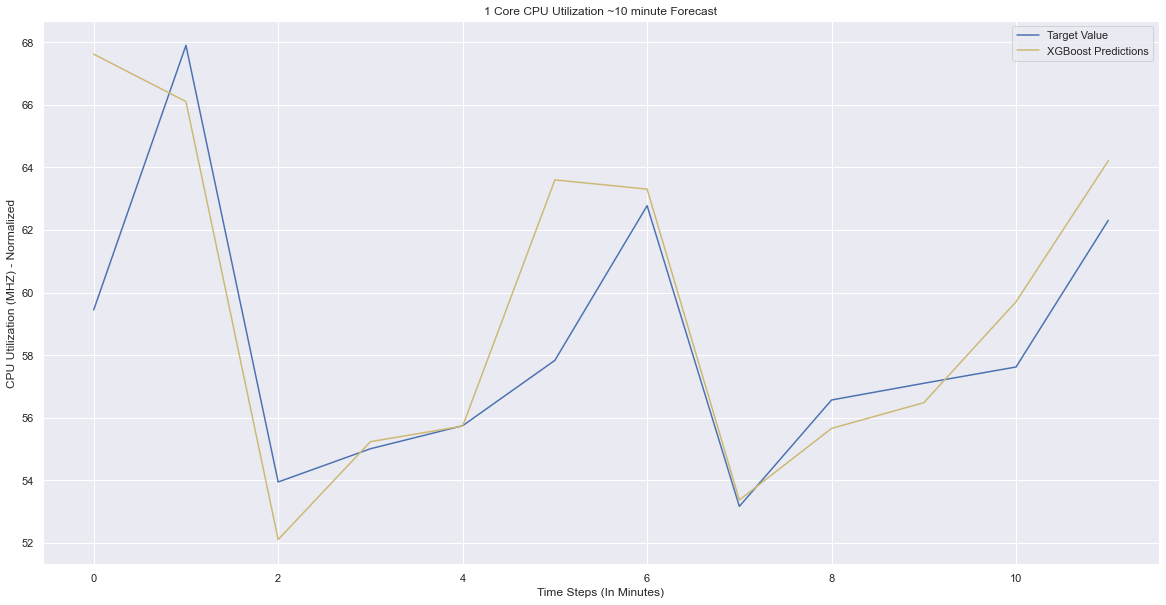

In [45]:
plot_pred(y_test1, xg1, '1')

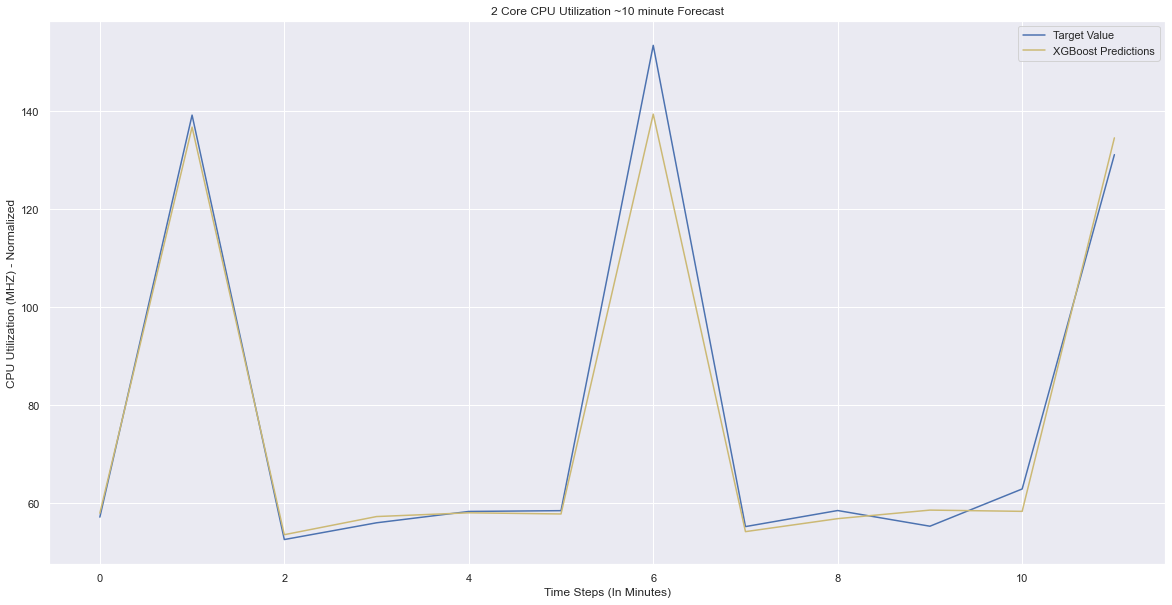

In [37]:
plot_pred(y_test2, xg2, '2')

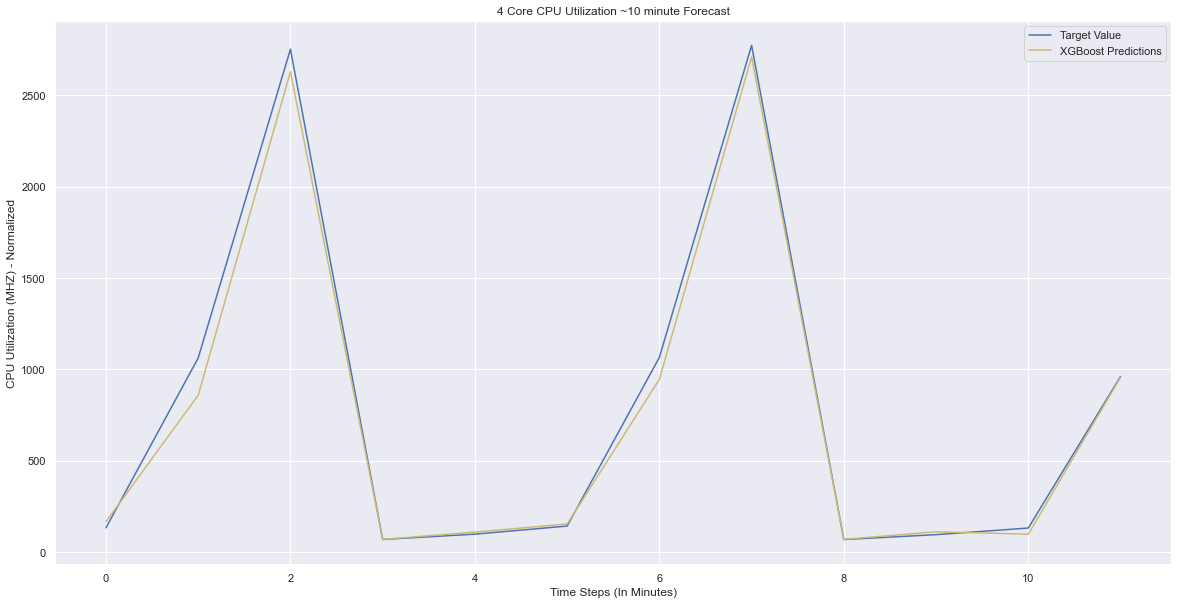

In [38]:
plot_pred(y_test4, xg4, '4')

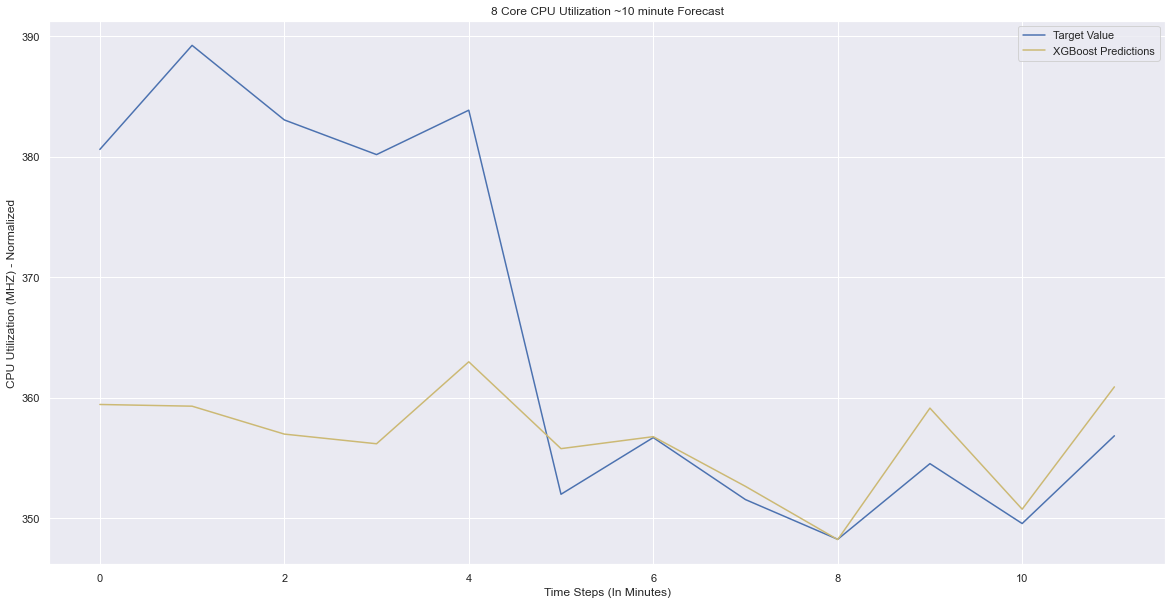

In [39]:
plot_pred(y_test8, xg8, '8')

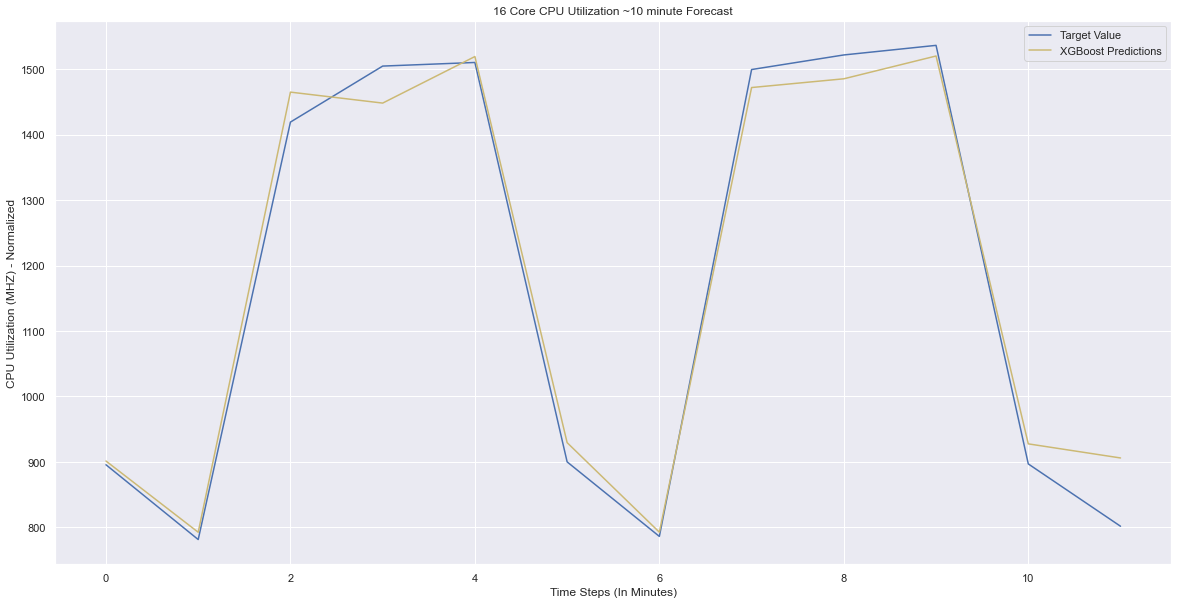

In [40]:
plot_pred(y_test16, xg16, '16')

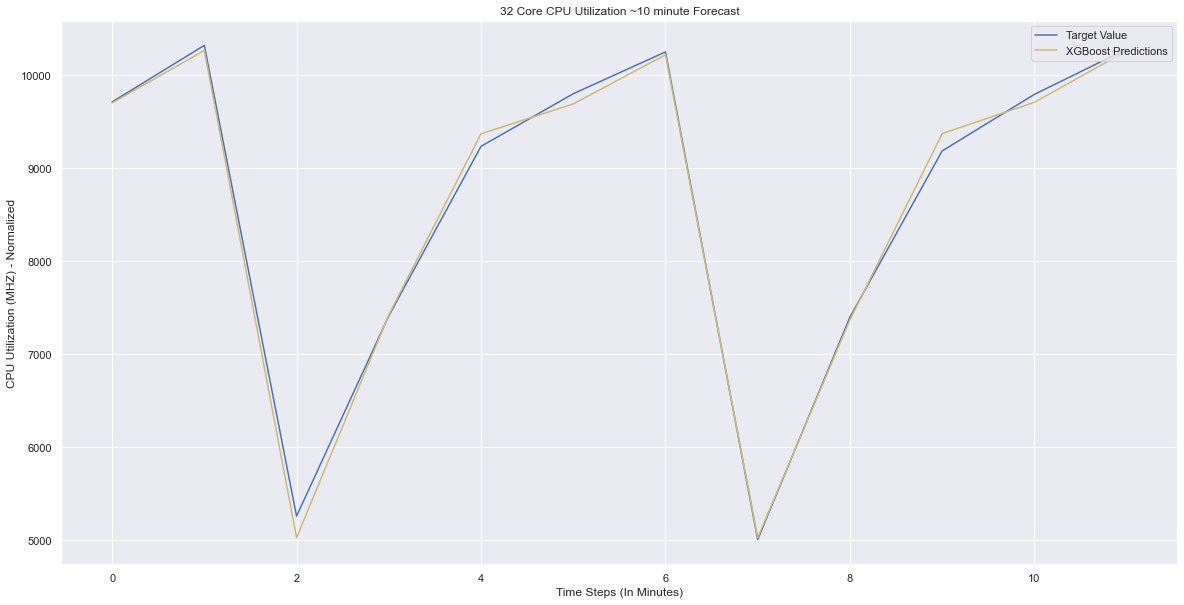

In [41]:
plot_pred(y_test32, xg32, '32')